### Installations et configurations :

In [1]:
!pip install -q graphframes

In [1]:
import igraph as ig
import os
# # !find /usr/local -name "pyspark"
os.environ["SPARK_HOME"] = "/home/djeghali/spark"
os.environ["JAVA_HOME"] = "/usr"


### Ouverture d'une session spark :

In [2]:
# Main imports
import findspark
from pyspark.sql import SparkSession
from pyspark import SparkConf

# for dataframe and udf
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql.types import *
from datetime import *

import pandas as pd


# initialise environment variables for spark
findspark.init()

# Start spark session
# --------------------------
def start_spark():
  local = "local[*]"
  appName = "TP"

  gf = "graphframes:graphframes:0.8.3-spark3.5-s_2.12"

  configLocale = SparkConf().setAppName(appName).setMaster(local).\
  set("spark.executor.memory", "6G").\
  set("spark.driver.memory","6G").\
  set("spark.sql.catalogImplementation","in-memory").\
  set("spark.jars.packages", gf)

  spark = SparkSession.builder.config(conf = configLocale).getOrCreate()
  sc = spark.sparkContext
  sc.setLogLevel("ERROR")

  spark.conf.set("spark.sql.autoBroadcastJoinThreshold","-1")

  # Adjust the query execution environment to the size of the cluster (4 cores)
  spark.conf.set("spark.sql.shuffle.partitions","4")
  print("session started, its id is ", sc.applicationId)
  return spark
spark = start_spark()


session started, its id is  local-1707224357882


### Lectures des fichiers : 

In [3]:

#Import GraphFrames
from graphframes import GraphFrame
from graphframes.lib import AggregateMessages as AM
# from graphframes.lib import Pregel

#For connectedComponents()
# !pwd
# !mkdir -p /content/checkpoints
# spark.sparkContext.setCheckpointDir('/content/checkpoints')

#Import networkx
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx


# Initialisez une session Spark
spark = SparkSession.builder.appName("LectureParquet").getOrCreate()
# Chemin vers le fichier Parquet compressé avec Snappy
parquet_file_10K = "local/data/BDLE_10K/*.snappy.parquet"
parquet_file_1M = "local/data/BDLE_1M/*.snappy.parquet"

# Lisez le fichier Parquet dans un DataFrame PySpark
data_10K = spark.read.format("parquet").option("compression", "snappy").load(parquet_file_10K)
data_1M = spark.read.format("parquet").option("compression", "snappy").load(parquet_file_1M)





In [4]:
# Affichez le contenu du DataFrame
data_10K.show()
print("Nombre de tuples dans les données de taille 10K  : ",data_10K.count())

+-----------+-----------+-----+
|     seqID1|     seqID2|  sim|
+-----------+-----------+-----+
|117761605:5|152890023:5| 97.8|
|152904885:3|155591878:2| 88.5|
|152887848:4|153682181:0|100.0|
|152937692:5| 80009514:2| 82.3|
|152990923:2|154549183:4| 98.0|
|152867782:1|153171917:1| 83.1|
| 15111981:2|153137370:1|100.0|
|152794195:0| 15280704:2| 96.9|
| 62963742:1| 63783418:5| 98.4|
|152170568:3|153062631:2| 97.6|
|152904832:4|154500443:5| 98.6|
|152745429:3| 22988511:2|100.0|
|153161980:3|154256473:0|100.0|
|152903373:4|154426964:5| 80.4|
|146010871:1|158434400:4| 98.7|
|153040013:0|156563807:1| 96.5|
|152933621:4|157634534:2| 96.8|
|153141720:0|155282497:0| 93.2|
|153082115:5|153887336:3| 90.0|
|153025447:3|155660759:1| 97.4|
+-----------+-----------+-----+
only showing top 20 rows

Nombre de tuples dans les données de taille 10K  :  20842


In [5]:
# Affichez le contenu du DataFrame 1M
data_1M.show()
print("Nombre de tuples dans les données de taille 1M : ",data_1M.count())

+--------------------+--------------------+-----+
|              seqID1|              seqID2|  sim|
+--------------------+--------------------+-----+
|          28266027:2|          30697475:4|100.0|
|         141099253:1|         142374057:2| 87.8|
|         100479579:0|          23509310:0| 83.9|
|         113579361:3|         114583521:5|100.0|
|         127898390:3|         142186630:2|100.0|
|          19430332:0|          78781103:4| 85.4|
|         141834541:2|         145255331:5|100.0|
|         103259805:4|          58392840:4| 83.3|
|         122611397:5|         143667719:3|100.0|
|          23535857:4|           4695744:1| 95.8|
|          41064011:0|          58827273:4|100.0|
|         107823489:0|         107855124:4| 85.1|
|METdb_00146-1-DN1...|METdb_00154-1-DN1...| 92.6|
|         156037355:1|         157677656:3| 88.9|
|          36873489:1|          89199423:1| 93.1|
|         119223634:3|         119895769:4| 88.7|
|         126499401:5|         140644518:1|100.0|


### Créations des igraphes :

In [6]:
# On converti en dataframe pandas :
data_10K = data_10K.toPandas()
data_1M = data_1M.toPandas()

-   Génération des igraphes : 

In [7]:
# Créarion d'un graphe  à partir des données lues :
data_10K_ig_graph = ig.Graph.TupleList(data_10K[['seqID1', 'seqID2']].itertuples(index=False), directed=False)
data_1M_ig_graph = ig.Graph.TupleList(data_1M[['seqID1', 'seqID2']].itertuples(index=False), directed=False)


-   Calcule du temps de calcule des composantes connexes : 

    -   Data 10 K : 

In [174]:
from time import time

def calcul_composantes(g):
    # Code du premier programme
    return g.components()


start_time = time()

# Calculer les composantes connexes
calcul_composantes(data_10K_ig_graph)

end_time = time()

# Afficher le temps d'exécution
execution_time_10K = end_time - start_time

print("Temps d'exécution :", execution_time_10K, "secondes")


Temps d'exécution : 0.007563591003417969 secondes


    -   Data 1 M : 

In [141]:

start_time = time()

# Calculer les composantes connexes
calcul_composantes(data_1M_ig_graph)

# Afficher le temps d'exécution
end_time = time()
execution_time_1M = end_time - start_time

print("Temps d'exécution :", execution_time_1M, "secondes")


Temps d'exécution : 0.6879611015319824 secondes


### Vérification du multiprocessing de igraphe :


In [227]:
import multiprocessing
from igraph import Graph
import multiprocessing


# Calculer les composantes connexes
# Créer deux processus pour exécuter les deux programmes en parallèle
    
p1 = multiprocessing.Process(target=calcul_composantes, args=(data_10K_ig_graph,))
p2 = multiprocessing.Process(target=calcul_composantes, args=(data_10K_ig_graph,))

start_time = time.time()

# Démarrer les deux processus
p1.start()
p2.start()

# Attendre que les deux processus se terminent
p1.join()
end_time = time.time()
execution_time_2proccessus = end_time - start_time

print("Temps d'exécution paralèlle :", execution_time_2proccessus, "secondes")

p2.join()

# Afficher le temps d'exécution
end_time = time.time()
execution_time_2proccessus = end_time - start_time

print("Temps d'exécution paralèlle :", execution_time_2proccessus, "secondes")


Temps d'exécution paralèlle : 0.09178948402404785 secondes
Temps d'exécution paralèlle : 0.1115109920501709 secondes


On remarque le temps d'éxécution totoal est presque égale au temps d'éxécution de la tache 1 , l'éxécution a bien eu lieu de manière parallèle

### Extraction de sous graphes avec seuilage sur les arcs (similarité égale à 100% ):

#### Sur des données de taille 10K:

        -   Seuillage : 

In [12]:
# Fonction pour filtrer les arêtes ayant une similarité de 100
def filter_edges(edge):
    index = edge.index  # Récupérer l'indice de l'arête dans le DataFrame d'origine
    similarity = data_10K.loc[index, 'sim']  # Récupérer la similarité de l'arête
    return similarity == 100

# Filtrer les arêtes
filtered_edges = data_10K_ig_graph.es.select(filter_edges)

# Créer un nouveau graphe contenant uniquement les arêtes filtrées
filtered_10K_edges_100 = filtered_edges.subgraph()


In [13]:
# Affichez le contenu du DataFrame 1M
print("Nombre de tuples dans les données de taille 10K après séléction que des arcs de sim = 100 : ",filtered_10K_edges_100.ecount())

Nombre de tuples dans les données de taille 10K après séléction que des arcs de sim = 100 :  4054


    -   Temps d'éxécution pour la détection des composantes connexes sur le graphe reduit :

In [14]:
start_time = time()

# Calculer les composantes connexes
components = filtered_10K_edges_100.components()

# Afficher les composantes connexes
# print("Composantes connexes :", components)

# Afficher le temps d'exécution
end_time = time()
execution_time_10K = end_time - start_time

print("Temps d'exécution :", execution_time_10K, "secondes")

Temps d'exécution : 0.048300981521606445 secondes


    -   AFfichage de la plus grande composante connexe du graphe de taille 10 K:

(20,)


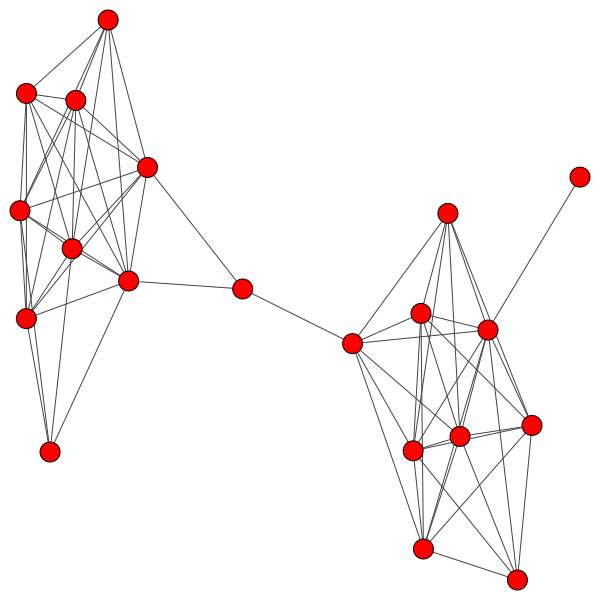

In [231]:

# Trier les composantes par taille (en ordre décroissant)
composantes_triees = sorted(components, key=len, reverse=True)

# Sélectionner la plus grande composante connexe
plus_grande_composante = composantes_triees[0]
print(np.array(plus_grande_composante).shape)
sous_graphe = data_10K_ig_graph.subgraph(plus_grande_composante)

ig.plot(sous_graphe)


#### Sur des données de taille 1M:

        -   Seuillage sur le graphe 1M: 

In [16]:
# Fonction pour filtrer les arêtes ayant une similarité de 100
def filter_edges(edge):
    index = edge.index  # Récupérer l'indice de l'arête dans le DataFrame d'origine
    similarity = data_1M.loc[index, 'sim']  # Récupérer la similarité de l'arête
    return similarity == 100

# Filtrer les arêtes
filtered_edges = data_1M_ig_graph.es.select(filter_edges)

# Créer un nouveau graphe contenant uniquement les arêtes filtrées
filtered_1M_edges_100 = filtered_edges.subgraph()


In [17]:
# Affichez le contenu du DataFrame 1M
print("Nombre de tuples dans les données de taille 1M après séléction que des arcs de sim = 100 : ",filtered_1M_edges_100.ecount())

Nombre de tuples dans les données de taille 1M après séléction que des arcs de sim = 100 :  375095


    -   Temps d'éxécution pour la détection des composantes connexes sur le graphe 1M reduit :

In [18]:
start_time = time()

# Calculer les composantes connexes
components = filtered_1M_edges_100.components()
end_time = time()

# Afficher les composantes connexes
print("Nombres de omposantes connexes :",len(components))

# Afficher le temps d'exécution
execution_time_10K = end_time - start_time

print("Temps d'exécution sur le graphe de taille 1M filtré (sim = 100):", execution_time_10K, "secondes")

Nombres de omposantes connexes : 209516
Temps d'exécution sur le graphe de taille 1M filtré (sim = 100): 0.2212080955505371 secondes
